# major_current_index

**Date:** <br>
11 March 2022 <br>
**Background:** <br>
Issue - https://github.com/Thomas-Moore-Creative/NCI-ACCESS-S2-ARD/issues/3 <br>
**Author(s):**<br>
Thomas Moore<br>

## We are using NCI OOD as platform for data processing
### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

## OOD cluster

In [4]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="23GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=12)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [6]:
client

<Client: 'tcp://10.0.128.149:37035' processes=6 threads=12, memory=128.52 GiB>

# open 025grid file for S2RA

In [7]:
S2RA_TUV = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.masked.AUSWCPregion.TUV_025deg.zarr',consolidated=True)

In [8]:
S2RA_TUV

<xarray.Dataset>
Dimensions:        (lat: 361, lon: 721, time: 492, depth: 75)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * lat            (lat) float64 -70.0 -69.75 -69.5 -69.25 ... 19.5 19.75 20.0
  * lon            (lon) float64 90.0 90.25 90.5 90.75 ... 269.5 269.8 270.0
  * time           (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2021-12-15
Data variables: (12/20)
    areat          (lat, lon) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>
    areau          (lat, lon) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>
    areav          (lat, lon) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>
    d20            (time, lat, lon) float32 dask.array<chunksize=(12, 361, 721), meta=np.ndarray>
    hc300          (time, lat, lon) float32 dask.array<chunksize=(12, 361, 721), meta=np.ndarray>
    maskT          (lat, lon) int64 dask.array<chunksize=(361, 721), meta=np.ndarray>
    ...             ...
    temp100        (time, lat, lon) float32 dask.array<chunksize=(12, 361, 721), meta=np.ndarray>
    temp200        (time, lat, lon) float32 dask.array<chunksize=(12, 361, 721), meta=np.ndarray>
    temp50         (time, lat, lon) float32 dask.array<chunksize=(12, 361, 721), meta=np.ndarray>
    temp500        (time, lat, lon) float32 dask.array<chunksize=(12, 361, 721), meta=np.ndarray>
    u              (time, depth, lat, lon) float32 dask.array<chunksize=(1, 75, 361, 721), meta=np.ndarray>
    v              (time, depth, lat, lon) float32 dask.array<chunksize=(1, 75, 361, 721), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [9]:
### set global option for keeping attributes across operations including arithmetic
xr.set_options(keep_attrs = True)

# Depth weights

# Grid information for ACCESS S2?

In [10]:
%%time
ds_S2_Tgrid = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/temp/mo_temp_1990.nc')

CPU times: user 87.5 ms, sys: 16 ms, total: 104 ms
Wall time: 293 ms


In [11]:
ds_S2_Tgrid

<xarray.Dataset>
Dimensions:            (y: 1021, x: 1442, deptht: 75, ndepth_bounds: 2, ncorners: 4, time_counter: 12, tbnds: 2)
Coordinates:
  * deptht             (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, ndepth_bounds, ncorners, tbnds
Data variables:
    areat              (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    deptht_bounds      (deptht, ndepth_bounds) float32 dask.array<chunksize=(75, 2), meta=np.ndarray>
    latt_bounds        (y, x, ncorners) float32 dask.array<chunksize=(1021, 1442, 4), meta=np.ndarray>
    lont_bounds        (y, x, ncorners) float32 dask.array<chunksize=(1021, 1442, 4), meta=np.ndarray>
    temp               (time_counter, deptht, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    07/04/2019 21:31:18 -0000
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    history:      Tue Jun 15 16:48:41 AEST 2021: File created using process d...

In [12]:
depth_weights = ds_S2_Tgrid.deptht_bounds.diff(dim='ndepth_bounds').squeeze().rename({'deptht':'depth'})
depth_weights.values

array([  1.0239066,   1.0792834,   1.1481192,   1.2337434,   1.3401852,
         1.4722052,   1.6352429,   1.8352118,   2.0780945,   2.369277 ,
         2.712654 ,   3.1096478,   3.5584164,   4.0536633,   4.5873146,
         5.150135 ,   5.7339096,   6.333458 ,   6.948097 ,   7.582039 ,
         8.244095 ,   8.946861 ,   9.705849 ,  10.538765 ,  11.465065 ,
        12.505692 ,  13.683044 ,  15.021072 ,  16.545197 ,  18.282547 ,
        20.261673 ,  22.512512 ,  25.065903 ,  27.952911 ,  31.204071 ,
        34.848145 ,  38.910614 ,  43.411926 ,  48.365784 ,  53.776886 ,
        59.638855 ,  65.93317  ,  72.62689  ,  79.67352  ,  87.01233  ,
        94.57056  , 102.265564 , 110.00891  , 117.70947  , 125.277954 ,
       132.63196  , 139.69739  , 146.41333  , 152.73181  , 158.6195   ,
       164.05664  , 169.03613  , 173.56226  , 177.64746  , 181.31226  ,
       184.5813   , 187.48242  , 190.04639  , 192.30273  , 194.28223  ,
       196.01294  , 197.52246  , 198.83594  , 199.97656  , 200.9

In [13]:
depth_weights = depth_weights.compute()

# We *do NOT* have transport volume flux calculated at run time saved in S2RA
### values are going to be velocity weighted by thickness of cells and summed - we still get $\frac{m^3}{s}$

In [14]:
weighted_v = S2RA_TUV.v * depth_weights

In [15]:
%%time
EAC_transport = weighted_v.sel({'lon':slice(154,159),'depth':slice(0,2000)}).sel({'lat':-27},method='nearest')\
    .sum(dim=('depth','lon'),skipna=True,keep_attrs = True).rename('EAC_transport')

CPU times: user 31.4 ms, sys: 6.12 ms, total: 37.5 ms
Wall time: 47.7 ms


In [16]:
%%time
EAC_transport_clim = helper.get_monthly_climatology(EAC_transport).rename('EAC_transport_clim')

CPU times: user 71.9 ms, sys: 5.79 ms, total: 77.7 ms
Wall time: 79.6 ms


In [17]:
%%time
EAC_transport_anom = helper.get_monthly_anomaly(EAC_transport,EAC_transport_clim).rename('EAC_transport_anom')

CPU times: user 103 ms, sys: 2.02 ms, total: 105 ms
Wall time: 104 ms


In [18]:
EAC_index = EAC_transport_anom * -1.0

Text(0.5, 1.0, 'ACCESS-S2 EAC N/S transport climatology  //  154 - 159E & 27S & 0-2000m')

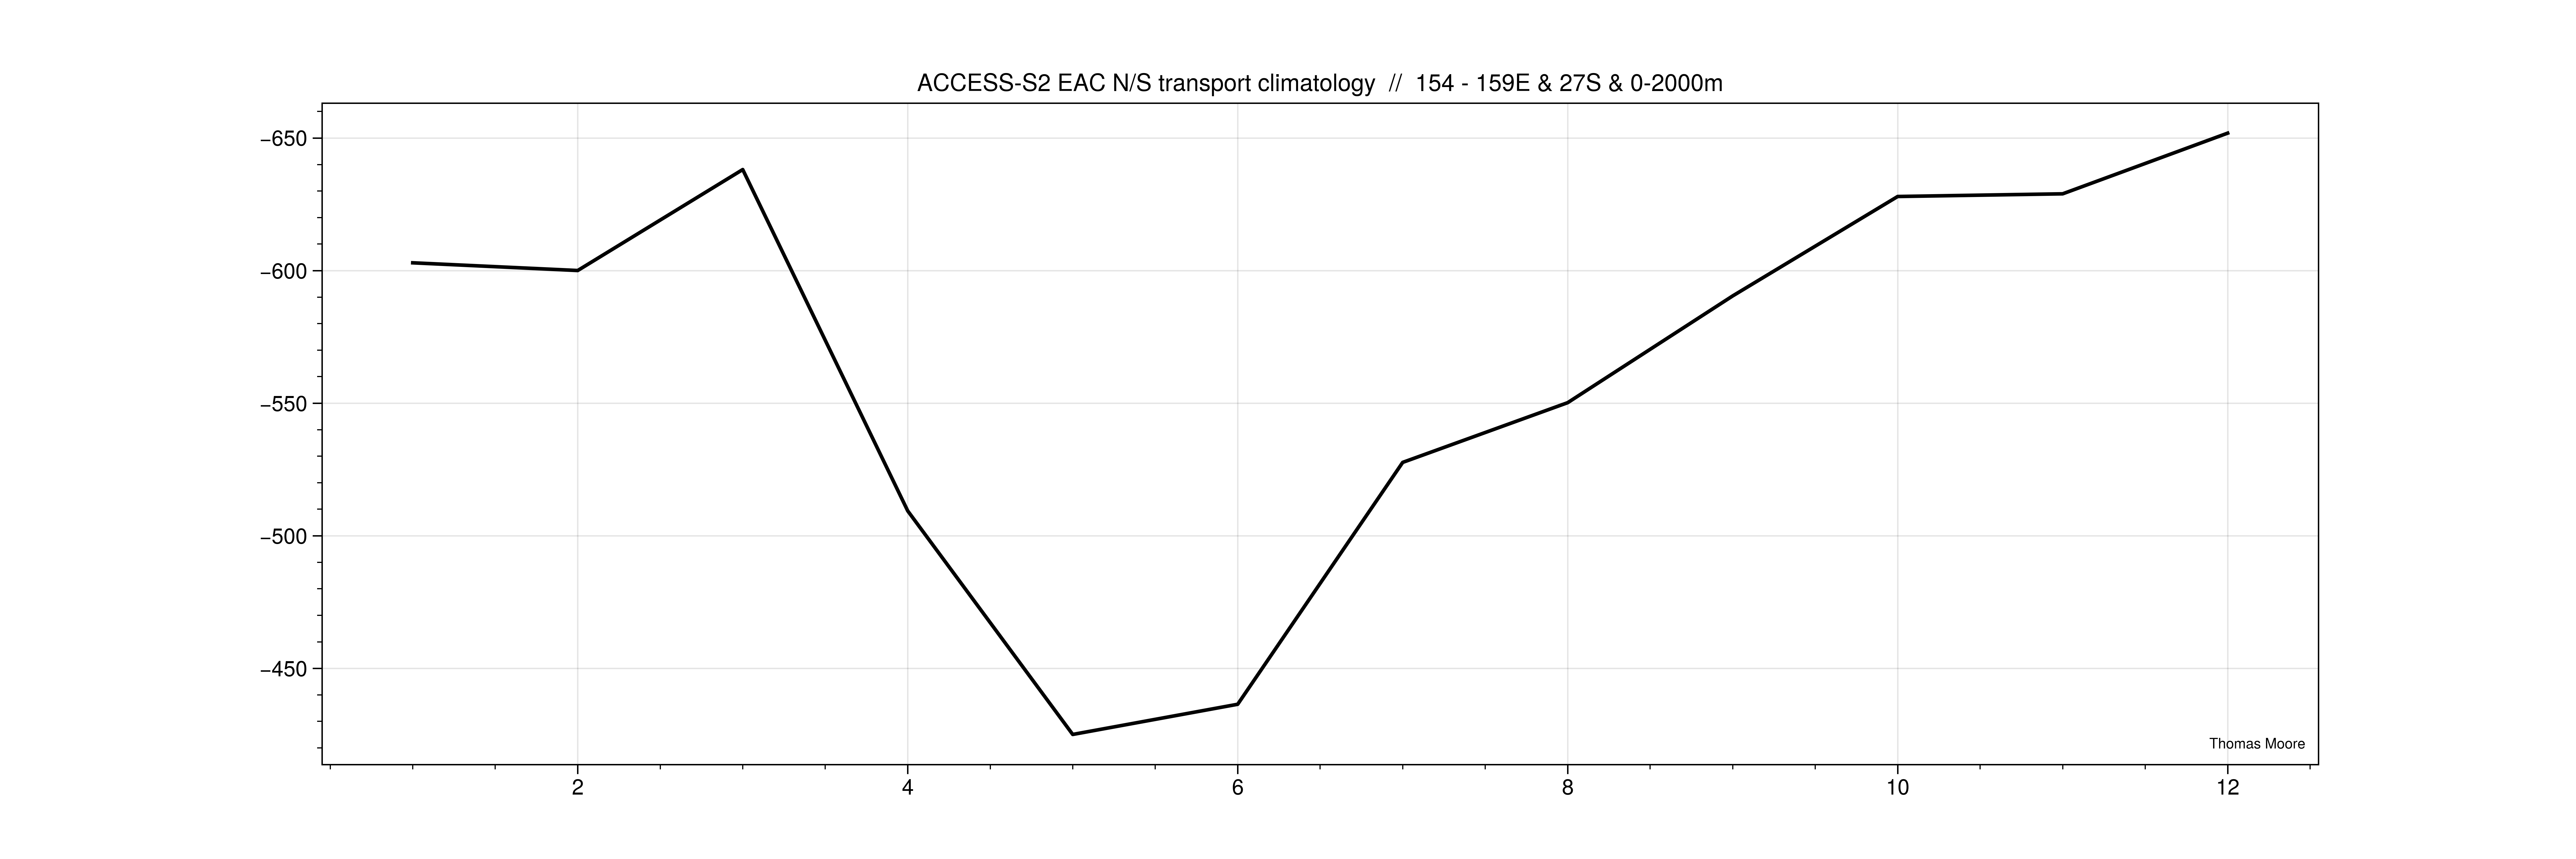

In [27]:
from matplotlib.offsetbox import AnchoredText
fig = plt.figure(figsize=(15, 5), dpi= 300, facecolor='w', edgecolor='k')
ax = plt.axes()
#ax.set_facecolor('grey')
ax.plot(EAC_transport_clim.month,EAC_transport_clim,color='black')
SOURCE = 'Thomas Moore'
    
text = AnchoredText(r'{}'
                        ''.format(SOURCE),
                       loc='lower right', prop={'size': 6}, frameon=False,
                       bbox_to_anchor=(1., 0.),
                       bbox_transform=ax.transAxes)
ax.add_artist(text)
plt.gca().invert_yaxis()

plt.title('ACCESS-S2 EAC N/S transport climatology  //  154 - 159E & 27S & 0-2000m')

Text(0.5, 1.0, 'CAFE60 EAC transport index // 154 - 159E & 27S & 0-2000m')

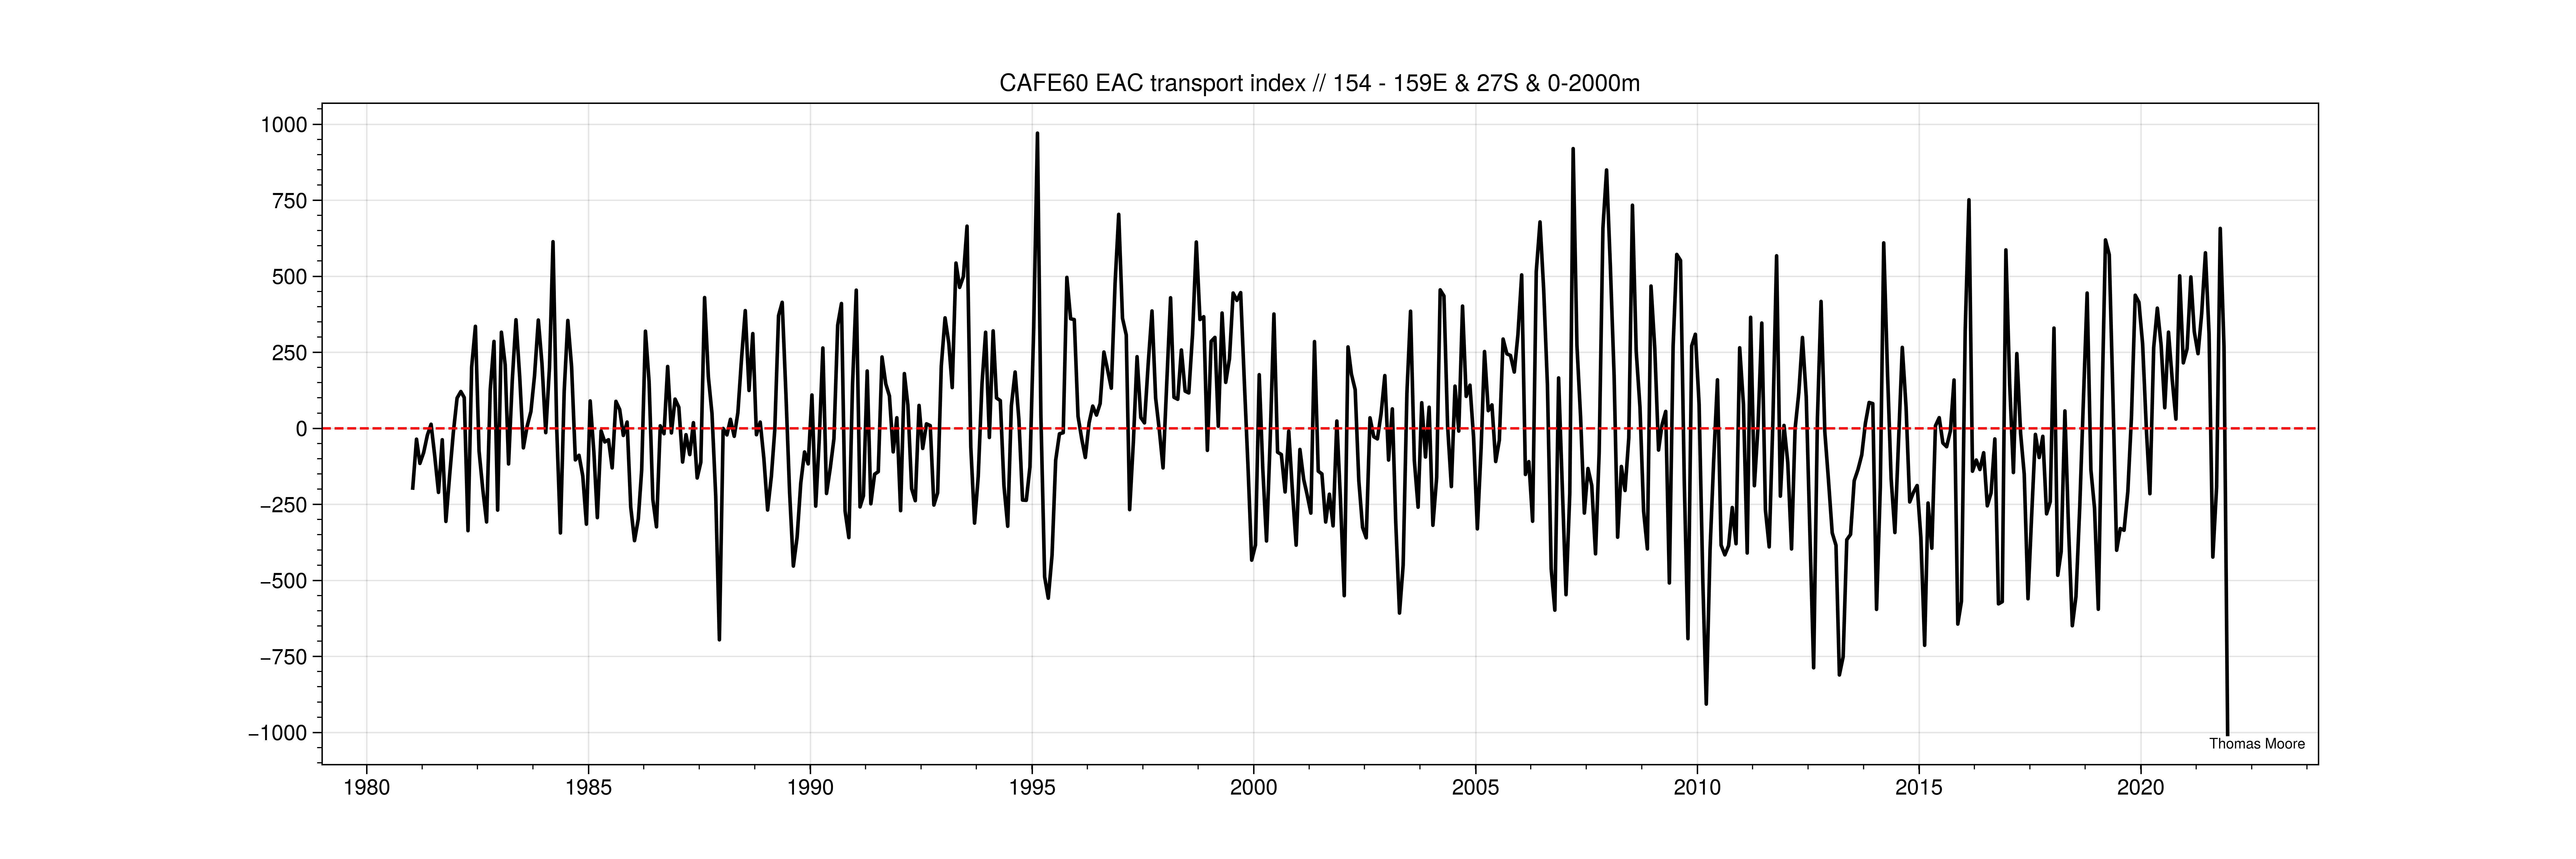

In [30]:
fig = plt.figure(figsize=(15, 5), dpi= 300, facecolor='w', edgecolor='k')
ax = plt.axes()
#ax.set_facecolor('grey')
ax.plot(EAC_index.time,EAC_index,color='black')
SOURCE = 'Thomas Moore'
    
text = AnchoredText(r'{}'
                        ''.format(SOURCE),
                       loc='lower right', prop={'size': 6}, frameon=False,
                       bbox_to_anchor=(1., 0.),
                       bbox_transform=ax.transAxes)
ax.add_artist(text)

plt.axhline(linewidth=1, color='r', linestyle ='--')

plt.title('CAFE60 EAC transport index // 154 - 159E & 27S & 0-2000m')

Text(0.5, 1.0, 'CAFE60 EAC transport index w/3 month rolling avg // 154 - 159E & 27S & 0-2000m')

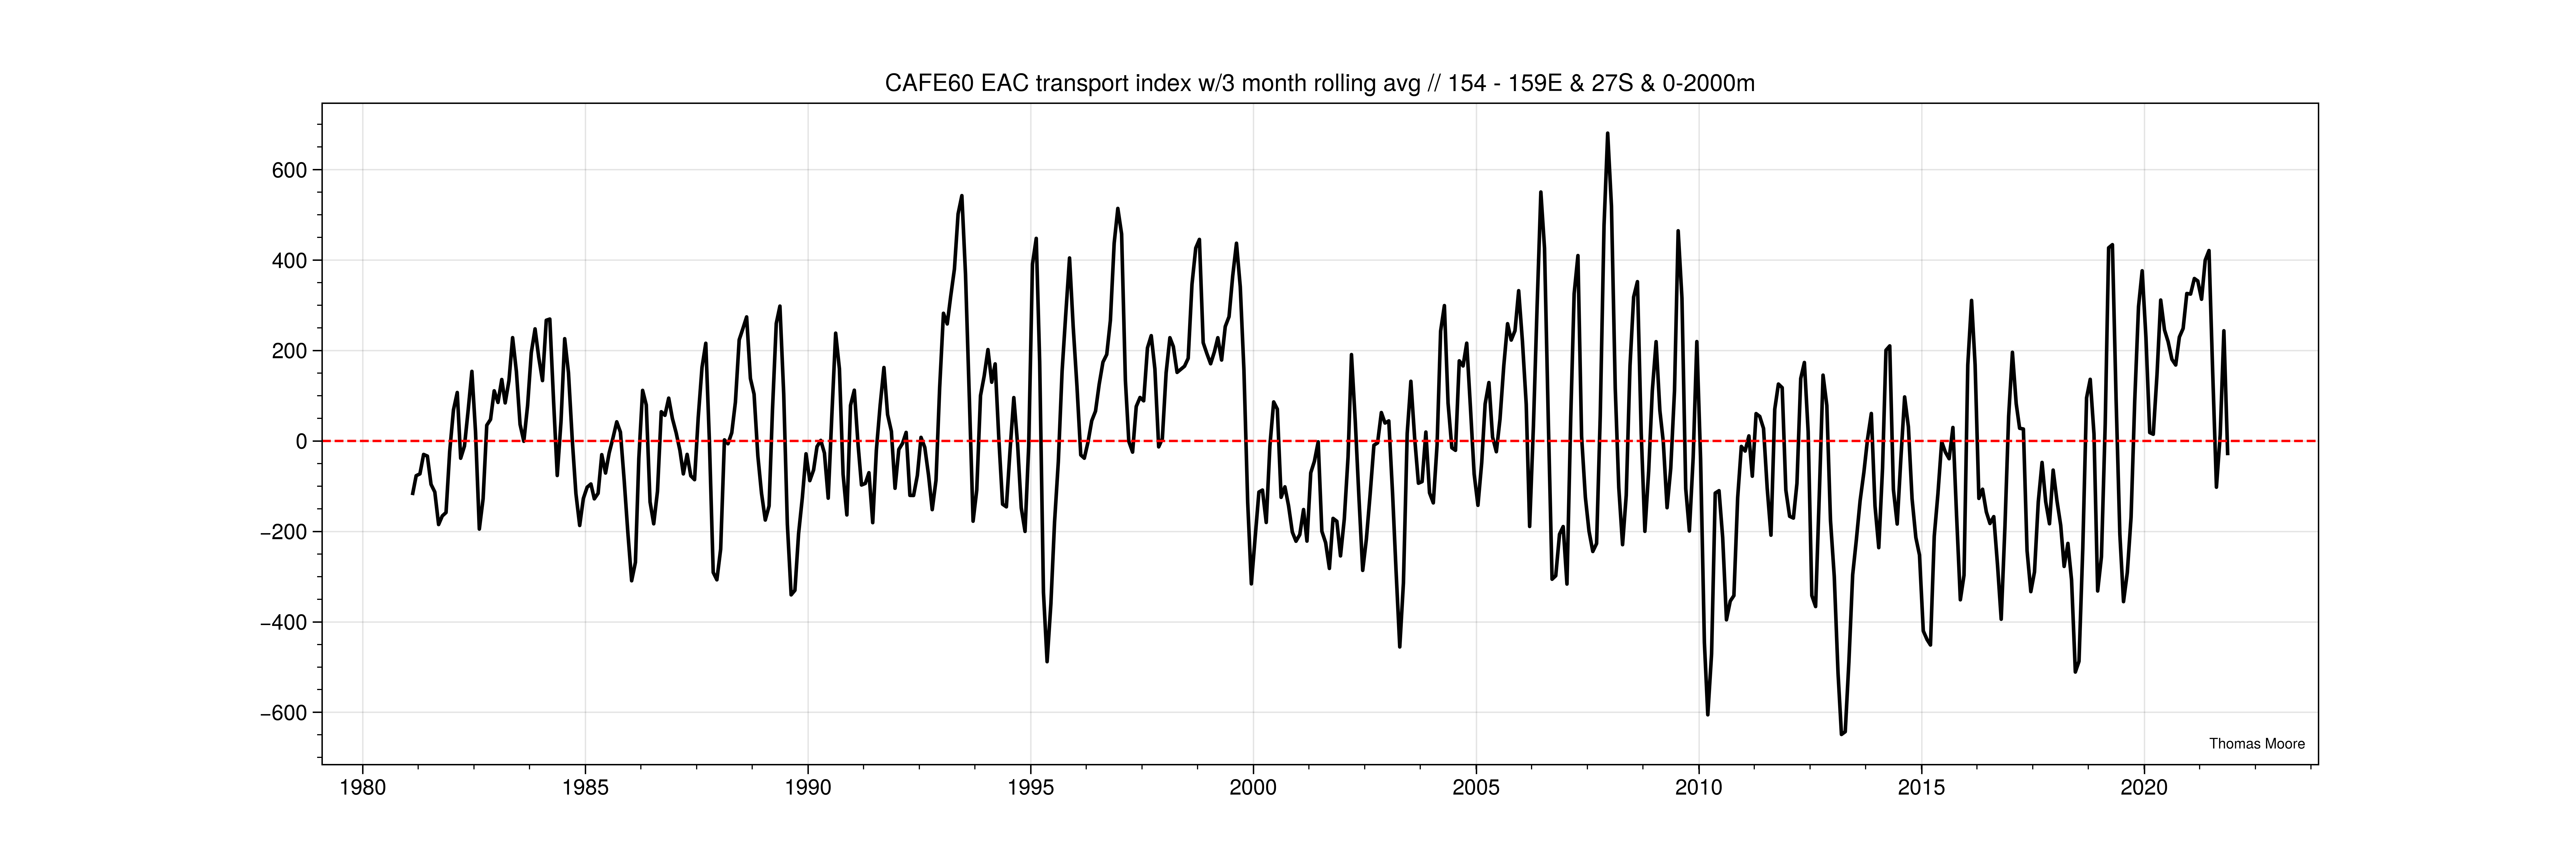

In [28]:
fig = plt.figure(figsize=(15, 5), dpi= 300, facecolor='w', edgecolor='k')
ax = plt.axes()
#ax.set_facecolor('grey')
ax.plot(EAC_index.time,EAC_index.rolling(time=3, center=True).mean(),color='black')
SOURCE = 'Thomas Moore'
    
text = AnchoredText(r'{}'
                        ''.format(SOURCE),
                       loc='lower right', prop={'size': 6}, frameon=False,
                       bbox_to_anchor=(1., 0.),
                       bbox_transform=ax.transAxes)
ax.add_artist(text)

plt.axhline(linewidth=1, color='r', linestyle ='--')

plt.title('CAFE60 EAC transport index w/3 month rolling avg // 154 - 159E & 27S & 0-2000m')

Text(0.5, 1.0, 'CAFE60 EAC transport index w/1 year rolling avg // 154 - 159E & 27S & 0-2000m')

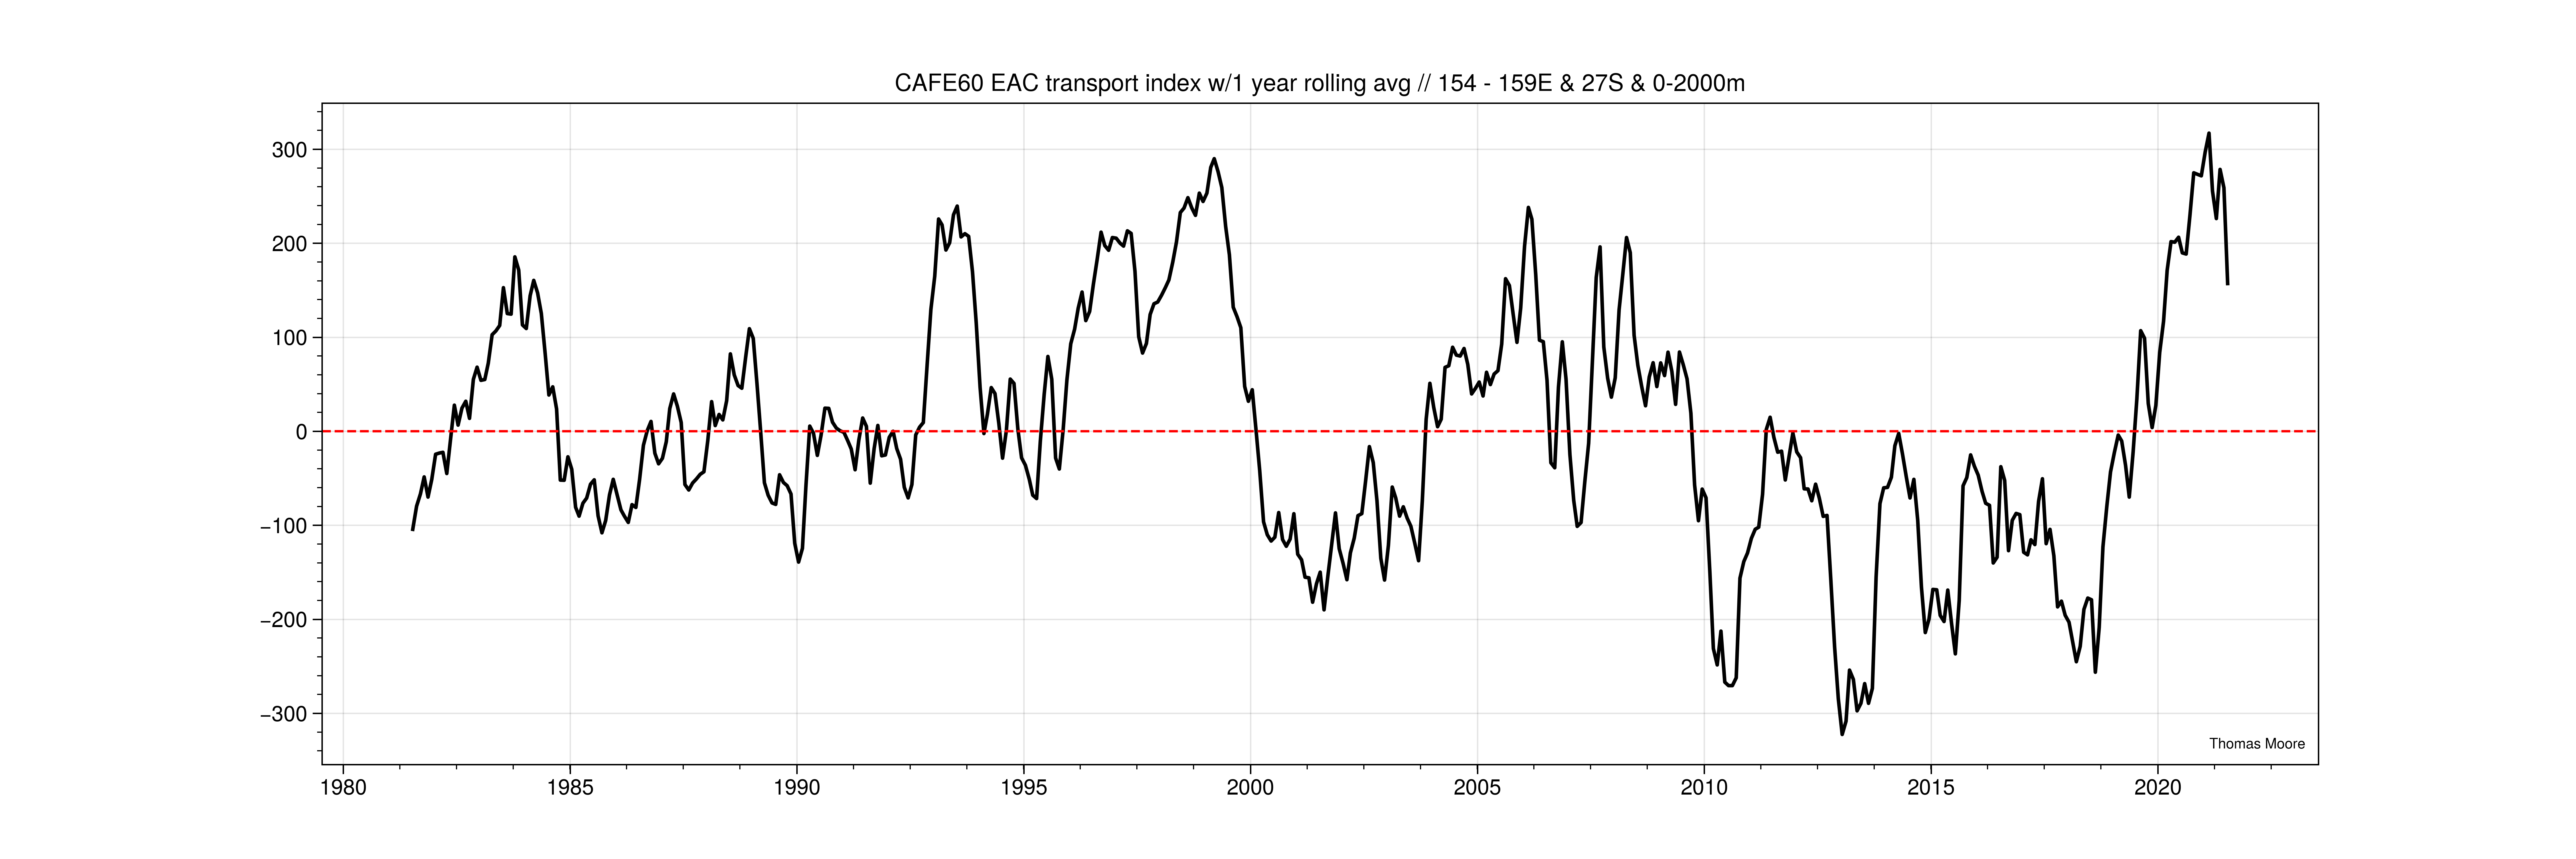

In [29]:
fig = plt.figure(figsize=(15, 5), dpi= 300, facecolor='w', edgecolor='k')
ax = plt.axes()
#ax.set_facecolor('grey')
ax.plot(EAC_index.time,EAC_index.rolling(time=12, center=True).mean(),color='black')
SOURCE = 'Thomas Moore'
    
text = AnchoredText(r'{}'
                        ''.format(SOURCE),
                       loc='lower right', prop={'size': 6}, frameon=False,
                       bbox_to_anchor=(1., 0.),
                       bbox_transform=ax.transAxes)
ax.add_artist(text)

plt.axhline(linewidth=1, color='r', linestyle ='--')

plt.title('CAFE60 EAC transport index w/1 year rolling avg // 154 - 159E & 27S & 0-2000m')

# SST testbed

In [ ]:
data_loc='/g/data/ux62/access-s2/hindcast/raw_model/ocean/sst/monthly/'
# y,m,start_day,t are the start date and time step of interest - try mo_sst_20030930_e01
limits = [0, 1442, 0, 1021] #global
num_ens=3
tl_days=9
first_letter='m'
fn_var = 'sst'
nc_var = 'sst'
y = 2003
m = 9
start_day= 30
t = 1

In [ ]:
def get_emn_from_ens_s2(data_loc,y,m,start_day,t,limits,first_letter,fn_var,nc_var,num_ens,tl_days):
    #Hindcast period and ensemble number hard coded
    tls=[]
    for tl in range(0,tl_days):
      ens=[]
 
      for e in range(1,num_ens+1):
 
        date_stamp=datetime.date(y,m,start_day)
        date_stamp=date_stamp-datetime.timedelta(days=tl)
        file=data_loc+'/e'+str(e).zfill(2)+'/'+first_letter+'o_'+fn_var+'_'+date_stamp.strftime("%Y%m%d")+'_e'+str(e).zfill(2)+'.nc'
        print(file)
 
        cdf=Dataset(file, 'r')
        data=cdf.variables[nc_var][t,0,limits[2]:limits[3]+1,limits[0]:limits[1]+1]
        cdf.close()
        ens.append(data)
      tls.append(np.nanmean(ens,axis=0))
    mask=np.ma.getmask(data)
    return tls,mask

In [ ]:
[tls,mask] = get_emn_from_ens_s2(data_loc,y,m,start_day,t,limits,first_letter,fn_var,nc_var,num_ens,tl_days)

In [ ]:
data = xr.open_dataset('/g/data/ux62/access-s2/hindcast/raw_model/ocean/sst/monthly/e01/mo_sst_20110528_e01.nc')

In [ ]:
data

### define preprocess drop function
##### this unfortunately removes useful information like areau that's missing from 2015 files

In [ ]:
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'latt_bounds' in ds.data_vars:
        ds = ds.drop(['latt_bounds'])
    if 'lont_bounds' in ds.data_vars:
        ds = ds.drop(['lont_bounds'])    
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])
    if 'deptht_bounds' in ds.data_vars:
        ds = ds.drop(['deptht_bounds'])
    if 'areat' in ds.data_vars:
        ds = ds.drop(['areat'])        
    return ds

In [ ]:
def drop_not_in_2015_and_fix_SSHname(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'latt_bounds' in ds.data_vars:
        ds = ds.drop(['latt_bounds'])
    if 'lont_bounds' in ds.data_vars:
        ds = ds.drop(['lont_bounds'])    
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])
    if 'deptht_bounds' in ds.data_vars:
        ds = ds.drop(['deptht_bounds'])
    if 'areat' in ds.data_vars:
        ds = ds.drop(['areat'])
    if 'ssh' in ds.data_vars:
        ds = ds.rename({'ssh':'ssh_corrected'})
    return ds

# "T-grid" variables // SST, SSS, SSH, MLD1-2,d20,HC300,td

### load the whole timeseries using `drop` preproccessor

In [ ]:
%%time
ds_SST = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_SSS = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sss/mo_sss_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_SSH = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/ssh_corrected/mo_ssh_corrected_*.nc',parallel=True,preprocess=drop_not_in_2015_and_fix_SSHname)

In [ ]:
%%time
ds_mld1 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld1/mo_mld1_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_mld2 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld2/mo_mld2_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_D20 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/d20/mo_d20_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_hc300 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/hc300/mo_hc300_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_td = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_temp = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/temp/mo_temp_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
ds_temp50 = ds_temp.sel(deptht=50,method='nearest').rename({'temp':'temp50'})
ds_temp100 = ds_temp.sel(deptht=100,method='nearest').rename({'temp':'temp100'})
ds_temp200 = ds_temp.sel(deptht=200,method='nearest').rename({'temp':'temp200'})
ds_temp500 = ds_temp.sel(deptht=500,method='nearest').rename({'temp':'temp500'})

In [ ]:
#some model variables need a squeeze, some don't
ds_ACCESS_S2_RA_ocean = xr.merge([ds_temp50.drop('deptht'),
                                  ds_temp100.drop('deptht'),
                                  ds_temp200.drop('deptht'),
                                  ds_temp500.drop('deptht'),
                                  ds_SST.squeeze(),
                                  ds_SSS.squeeze(),
                                  ds_SSH,
                                  ds_mld1,
                                  ds_mld2,
                                  ds_D20,
                                  ds_hc300,
                                  ds_td
                                 ],compat='override')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('time_counter_bnds')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('deptht')
ds_ACCESS_S2_RA_ocean

## add back in key metadata

In [ ]:
areat = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_2016.nc',parallel=True)).areat.to_dataset()
areau = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_2016.nc',parallel=True)).areau.to_dataset()
areav = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_2016.nc',parallel=True)).areav.to_dataset()

In [ ]:
ds_ACCESS_S2_RA_ocean = xr.combine_by_coords([ds_ACCESS_S2_RA_ocean,areat])
ds_ACCESS_S2_RA_ocean

# rename time and lat/lon

In [ ]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'time_counter':'time'})

In [ ]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
ds_ACCESS_S2_RA_ocean

In [ ]:
ds_ACCESS_S2_RA_ocean.nbytes/1e9

# Deal with inconsistant and crazy dates across collection of S2 netcdf files

In [ ]:
S2_time_df = ds_ACCESS_S2_RA_ocean.time.to_dataframe()
truncated_S2_time = pd.to_datetime(S2_time_df.time).dt.date
year_month_day_strings = [ string[:-2]+'15' for string in truncated_S2_time.astype(str) ]
new_S2_datetime = pd.to_datetime(year_month_day_strings)
#replace time with cleaned version
ds_ACCESS_S2_RA_ocean['time'] = new_S2_datetime

# SAVE ocean tgrid zarr file

### rechunk to make chunks consistent

In [ ]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.chunk({"x": 1442, "y": 1021,"time":12})

In [ ]:
%%time
ds_ACCESS_S2_RA_ocean.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip above
# $\Downarrow$

In [ ]:
ds_ACCESS_S2_RA_ocean_nativeTgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

In [ ]:
%%time
ds_ACCESS_S2_RA_ocean_nativeTgrid.ssh_corrected.mean('time').plot(robust=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.ylim([200, 400])
plt.xlim([300, 500])
plt.xlabel('x')
plt.ylabel('y')
plt.title('ssh')

# file size

In [ ]:
ds_ACCESS_S2_RA_ocean_nativeTgrid.nbytes/1e9

# U & V

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip arrows if you can
# $\Downarrow$

# ACCESS-S2 ocean reanalysis (RA) 1981 - 2018

# load U & V S2_RA

In [ ]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_u = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_u

In [ ]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_v = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_v

# THIS IS LOST BELOW IN RECHUNKING add missing area metdata back in

In [ ]:
ds_u = xr.combine_by_coords([ds_u,areau])
ds_v = xr.combine_by_coords([ds_v,areav])

# Deal with the same depth coordinates given two different names & rename time

In [ ]:
ds_u = ds_u.rename({'depthu':'depth','time_counter':'time'})
ds_v = ds_v.rename({'depthv':'depth','time_counter':'time'})

# rename lat/lon

In [ ]:
ds_u = ds_u.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
ds_v = ds_v.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})

# Deal with inconsistant and crazy dates (use time from Tgrid zarr already corrected)

In [ ]:
new_time = ds_ACCESS_S2_RA_ocean_nativeTgrid.time

In [ ]:
ds_u['time'] = new_time
ds_v['time'] = new_time

In [ ]:
ds_u

# Double Check for bugged time stamps

In [ ]:
u_time = ds_u.time.values
v_time = ds_v.time.values
ds_ACCESS_S2_RA_ocean_nativeTgrid_time = ds_ACCESS_S2_RA_ocean_nativeTgrid.time.values

In [ ]:
compare_UV = (u_time == v_time)
np.where(compare_UV==False)

In [ ]:
u_time[236]

In [ ]:
v_time[236]

In [ ]:
ds_ACCESS_S2_RA_ocean_nativeTgrid_time[236]

In [ ]:
u_time[329]

In [ ]:
v_time[329]

In [ ]:
ds_ACCESS_S2_RA_ocean_nativeTgrid_time[329]

# Checks out

# drop `time_counter_bounds` var

In [ ]:
ds_u = ds_u.drop('time_counter_bnds')
ds_v = ds_v.drop('time_counter_bnds')

# re-chunk with rechunker!
# and write out native grid U & V zarr collections

In [ ]:
ds_u = ds_u[['u','areau']]
# not sure this encoding reset is needed #
for var in ds_u.variables:
        ds_u[var].encoding = {}

In [ ]:
ds_u

In [ ]:
%%time
target_chunks = {
        'u': {'time':492,'depth':1,'x':250,'y':250},
        'areau':{'x':1442,'y':1021},
        'time': None,
        'depth': None}

mem_max = '10GB'

target_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr'
temp_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked-tmp.zarr'
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/.rechunker/*.zarr

array_plan = rechunk(ds_u, target_chunks, mem_max, target_store,temp_store=temp_store)
rechunked_result = array_plan.execute()
print('final chunking scheme:'+str(rechunked_result.u.chunks))
ds_u_rechunked = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr',
                             consolidated=False)
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr
ds_u_rechunked.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',
                                         consolidated=True)

In [ ]:
ds_v = ds_v[['v','areav']]
# not sure this encoding reset is needed #
for var in ds_v.variables:
        ds_v[var].encoding = {}

In [ ]:
%%time
target_chunks = {
        'v': {'time':492,'depth':1,'x':250,'y':250},
        'areav':{'x':1442,'y':1021},
        'time': None,
        'depth': None}

mem_max = '10GB'

target_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr'
temp_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked-tmp.zarr'
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/.rechunker/*.zarr

array_plan = rechunk(ds_v, target_chunks, mem_max, target_store,temp_store=temp_store)
rechunked_result = array_plan.execute()
print('final chunking scheme:'+str(rechunked_result.v.chunks))
ds_v_rechunked = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr',
                             consolidated=False)
#! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr
ds_v_rechunked.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr',
                                         consolidated=True)

# $\Downarrow$
# CAN SKIP TO THIS STEP IF U & V `ZARR` FILES ARE WRITTEN AND AVAILABLE
hard part for u & v done above

In [ ]:
u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',consolidated=True)
v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr',consolidated=True)

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [37]:
client.restart()

<Client: 'tcp://10.0.128.134:45903' processes=0 threads=0, memory=0 B>

In [ ]:
client.shutdown()

In [ ]:
client.restart()